In [1]:
from deep_traffic_generation.tcvae import TCVAE
from deep_traffic_generation.VAE_Generation import SingleStageVAE
from traffic.algorithms.generation import Generation
from deep_traffic_generation.core.datasets import TrafficDataset

from sklearn.preprocessing import MinMaxScaler
import torch
import numpy as np
from os import walk

In [2]:
dataset = TrafficDataset.from_file(
    # "../../deep_traffic_generation/data/traffic_noga_tilFAF_train_enriched.pkl",
    "../../deep_traffic_generation/data/traffic_noga_tilFAF_train.pkl",
    features=["track", "groundspeed", "altitude", "timedelta"],
    scaler=MinMaxScaler(feature_range=(-1,1)),
    shape="image",
    info_params={"features": ["latitude", "longitude"], "index": -1},
)

test = TrafficDataset.from_file(
    "../../deep_traffic_generation/data/traffic_noga_tilFAF_test.pkl",
    features=["track", "groundspeed", "altitude", "timedelta"],
    # scaler=MinMaxScaler(feature_range=(-1,1)),
    scaler=dataset.scaler,
    shape="image",
    info_params={"features": ["latitude", "longitude"], "index": -1},
)

In [3]:
path = "../../deep_traffic_generation/lightning_logs/tcvae/version_1/"

t = SingleStageVAE(X = dataset, sim_type = "generation")
t.load(path, dataset.parameters)
g = Generation(generation=t, features = t.VAE.hparams.features, scaler=dataset.scaler) 

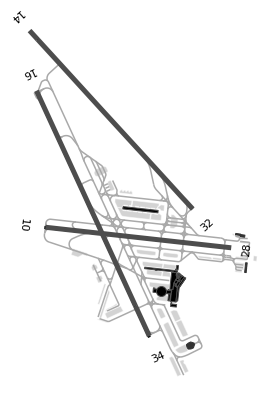

In [7]:
from traffic.data import airports
import matplotlib.pyplot as plt
from traffic.core.projection import EuroPP

with plt.style.context('traffic'):
    fig, ax = plt.subplots(subplot_kw=dict(projection=EuroPP()))
    airports['LSZH'].plot(ax, labels=dict(fontsize=11))
    ax.spines['geo'].set_visible(False)

# Latent Space

Explained variance ratio :  [0.29792726 0.15523952]
Clustering done
traffic :  0
traffic :  1
traffic :  2
traffic :  3
traffic :  4
traffic :  5
traffic :  6


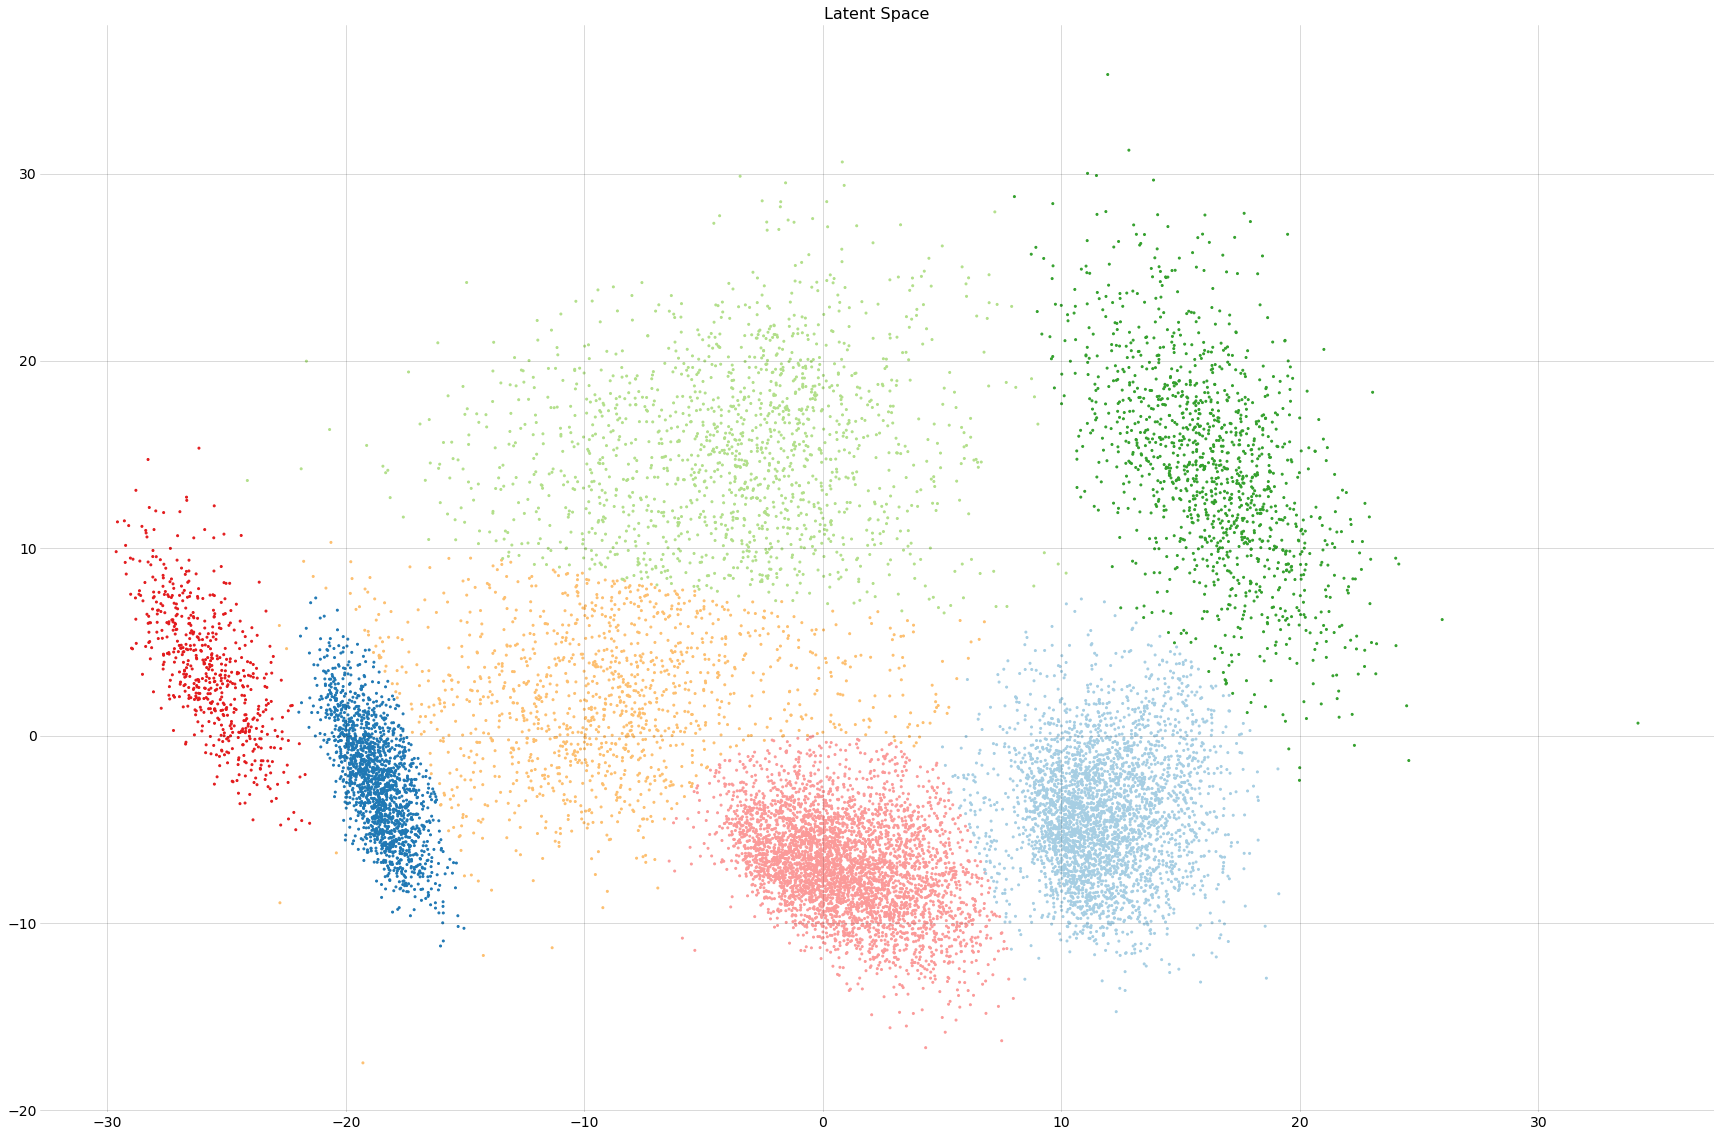

In [13]:
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
from traffic.core.projection import EuroPP
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from traffic.drawing import countries

n_gen = 1
Z = t.latent_space(n_gen)

#Only fitted on train data
pca = PCA(n_components=2).fit(Z[:-n_gen])
Z_embedded = pca.transform(Z)

print("Explained variance ratio : ", pca.explained_variance_ratio_)

# cluster = SpectralClustering(n_clusters=6).fit(Z_embedded) #gamma = 6 ?
# cluster = KMeans(n_clusters=7, random_state=0).fit(Z_embedded)
# labels = cluster.labels_
labels = GaussianMixture(n_components=7).fit_predict(Z_embedded)
print("Clustering done")

traffics = []
for i in np.unique(labels):
    print("traffic : ", i)
    decoded = t.decode(torch.Tensor(Z[labels == i]))
    traffics.append(g.build_traffic(decoded, coordinates = dict(latitude = 47.546585, longitude = 8.447731), forward=False))


color_cycle = "#a6cee3 #1f78b4 #b2df8a #33a02c #fb9a99 #e31a1c #fdbf6f #ff7f00 #cab2d6 #6a3d9a #ffff99 #b15928".split()
# colors = [color_cycle[i] for i in cluster.labels_]
colors = [color_cycle[i] for i in labels]

with plt.style.context("traffic"):
    fig = plt.figure(figsize=(30, 20))
    ax = fig.add_subplot(111)

    scat2 = ax.scatter(Z_embedded[:, 0], Z_embedded[:, 1], s=4, c = colors)
    ax.title.set_text("Latent Space")

    plt.show()

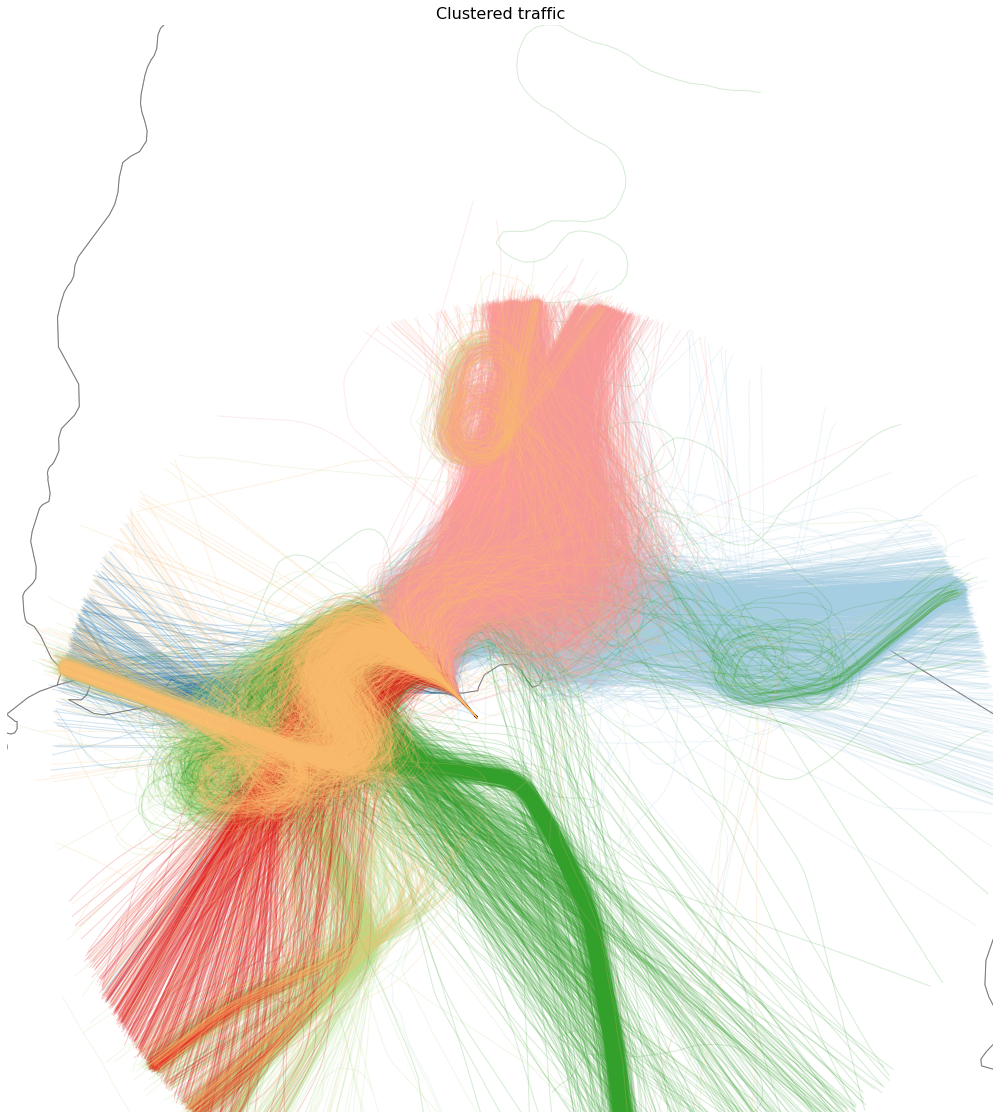

In [14]:
from traffic.core.projection import EuroPP

with plt.style.context("traffic"):
    fig = plt.figure(figsize=(30, 20))
    ax = fig.add_subplot(111, projection=EuroPP())

    ax.add_feature(countries())
    ax.figure
    ax.set_extent((7.5, 9.5, 47, 48.5))
    ax.title.set_text("Clustered traffic")
    for i, traffic in enumerate(traffics) :
        traffic.plot(ax, alpha=0.2, color = color_cycle[i])

    plt.show()

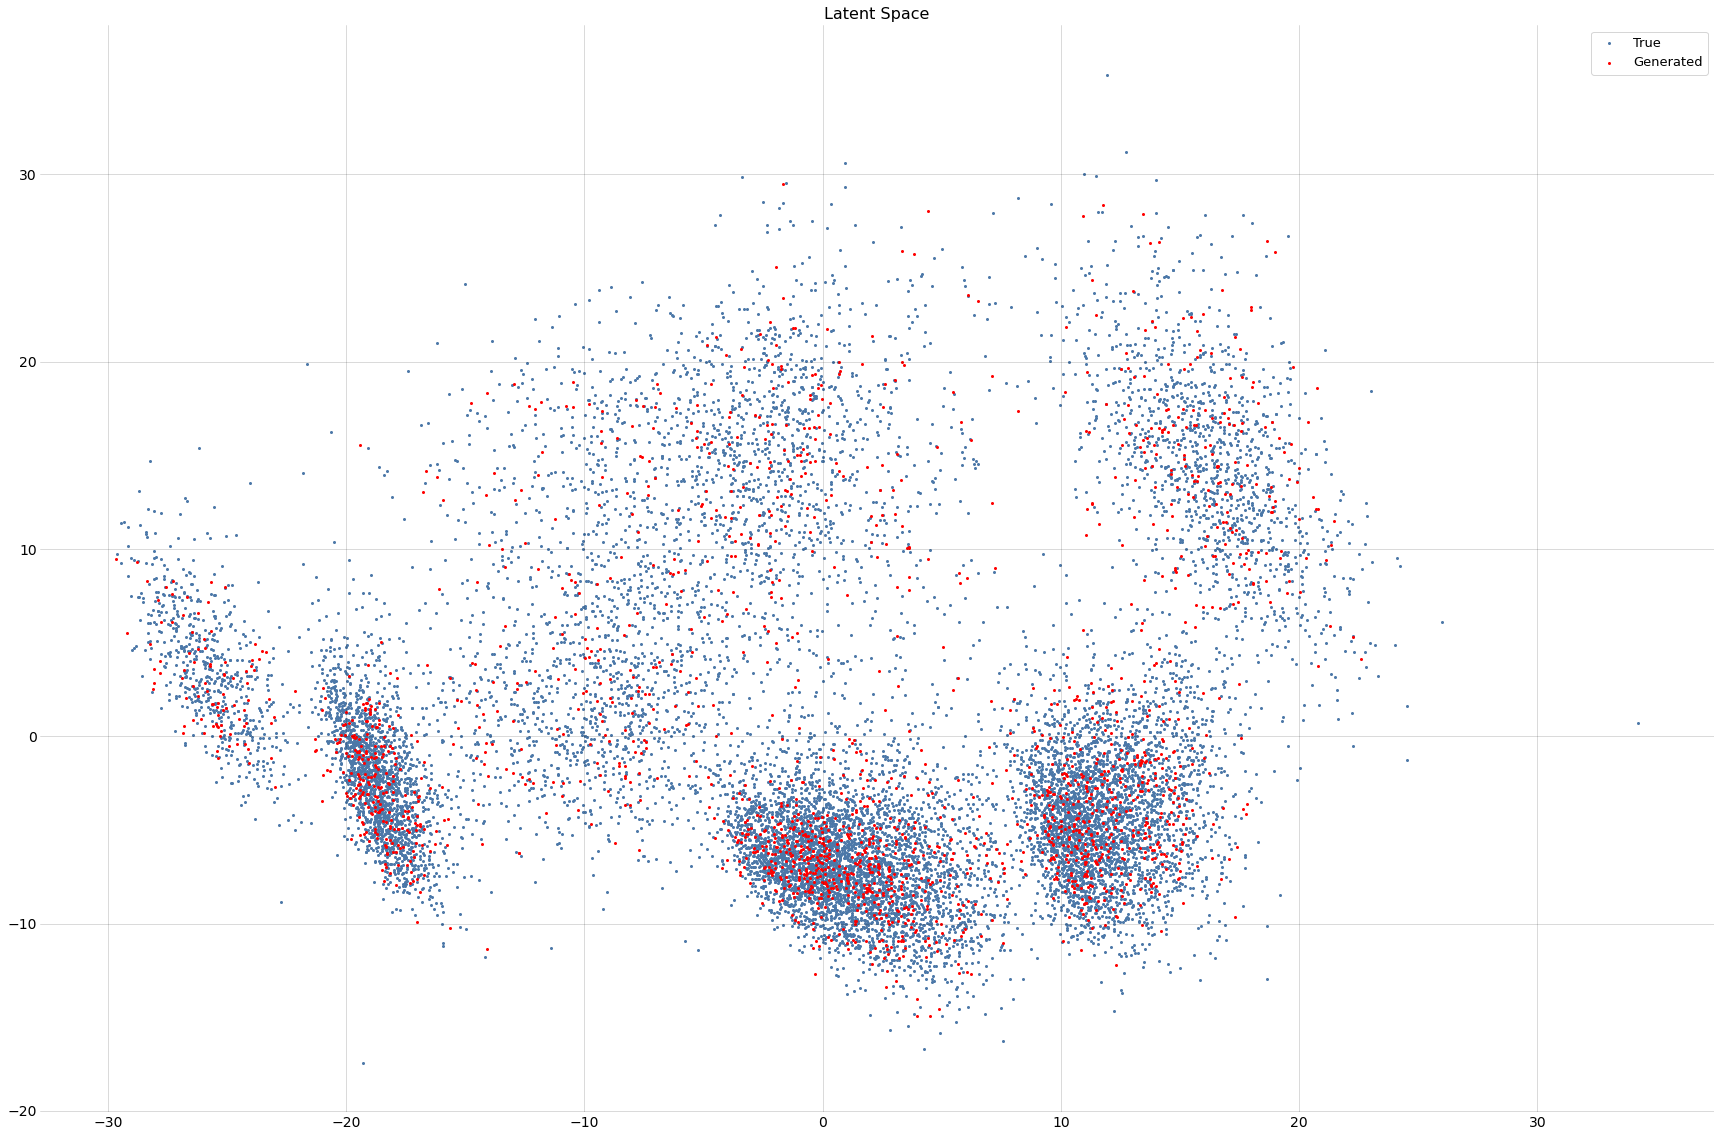

In [11]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

n_gen = 2000
Z = t.latent_space(n_gen)

#Only fitted on train data
pca = PCA(n_components=2).fit(Z[:-n_gen])
Z_embedded = pca.transform(Z)

with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, figsize=(30, 20))

    ax.scatter(Z_embedded[:-n_gen, 0], Z_embedded[:-n_gen, 1], s=4, label = "True")
    ax.scatter(Z_embedded[-n_gen:, 0], Z_embedded[-n_gen:, 1], s=4, c='red', label = "Generated")
    ax.title.set_text("Latent Space")
    ax.legend()

    plt.show()

# Reconstruction

airports @ourairports.com  84% ━━━━━━━━━━━╸━━ 2,676/3,168  [ 0:00:01 < 0:00:01 , 2,215 it/s ]

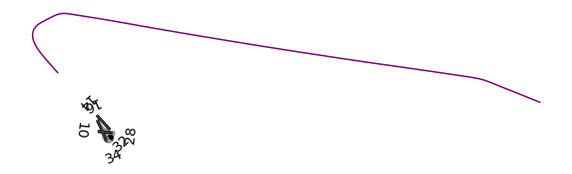

In [12]:
from traffic.core.projection import EuroPP
from traffic.data import airports
from traffic.drawing import countries
import matplotlib.pyplot as plt

j = np.random.randint(len(dataset))

original = dataset.data[j].unsqueeze(0)
original = original.transpose(1,2).reshape((original.shape[0], -1))
original = dataset.scaler.inverse_transform(original)
original_traf = g.build_traffic(original, coordinates = dict(latitude = 47.546585, longitude = 8.447731), forward=False)

h = t.VAE.encoder(dataset.data[j].unsqueeze(0))
z = t.VAE.lsr(h).rsample()
reconstructed = t.decode(z)
reconstructed_traf = g.build_traffic(reconstructed, coordinates = dict(latitude = 47.546585, longitude = 8.447731), forward=False)


with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, subplot_kw=dict(projection=EuroPP()))
    # ax.set_title("Reconstruction")
    original_traf.plot(ax, c="purple", label="Original")
    # reconstructed_traf.plot(ax, c="orange", label = "Reconstructed")
    # plt.legend()

    airports["LSZH"].plot(ax, footprint=True, runways=dict(lw=1), labels=False)
    airports["LSZH"].runways.plot(
        ax,
        runways=False,
        labels=True,
        shift=3000,
        text_kw=dict(fontname="Fira Sans", fontsize=14),
    )

    plt.show()

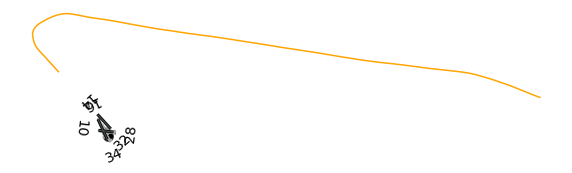

In [13]:
with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, subplot_kw=dict(projection=EuroPP()))
    # ax.set_title("Reconstruction")
    # original_traf.plot(ax, c="purple", label="Original")
    reconstructed_traf.plot(ax, c="orange", label = "Reconstructed")
    # plt.legend()

    airports["LSZH"].plot(ax, footprint=True, runways=dict(lw=1), labels=False)
    airports["LSZH"].runways.plot(
        ax,
        runways=False,
        labels=True,
        shift=3000,
        text_kw=dict(fontname="Fira Sans", fontsize=14),
    )

    plt.show()

# Pseudo Inputs

In [4]:
#Computing the pseudo inputs

#Vampprior
pseudo_X = t.VAE.lsr.pseudo_inputs_NN(t.VAE.lsr.idle_input) 
pseudo_X = pseudo_X.view((pseudo_X.shape[0], 4, 200))

#Exemplar
# pseudo_X = t.VAE.lsr.prior_trajs

pseudo_h = t.VAE.encoder(pseudo_X)
pseudo_means = t.VAE.lsr.z_loc(pseudo_h)

#Vampprior
pseudo_scales = (t.VAE.lsr.z_log_var(pseudo_h) / 2).exp()

#Exemplar
# pseudo_scales = t.VAE.lsr.prior_vars

#The pseudo-inputs themselves don't have any meaning; they are not realistic trajectories at all
#They have meanings once they are put through the decoder
#So the entire VAE is able to reconstruct sensible trajectories event though the input is not a trajectory but has the good properties
#That's impossible to plot the pseudo inputs trajectories per se

# pseudo_X[0] #VS dataset.data[0]

  93% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━ 926/1,000  [ 0:00:02 < 0:00:01 , 486 it/s ]

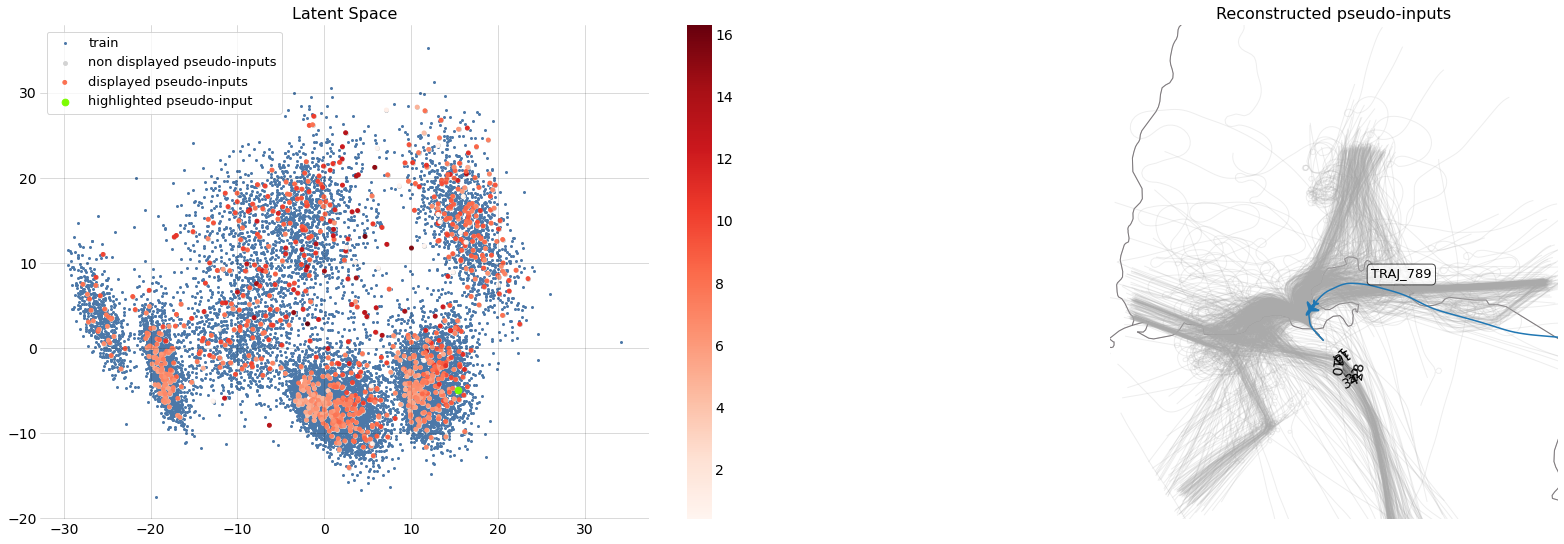

In [8]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from traffic.core.projection import EuroPP
from traffic.data import airports
from traffic.drawing import countries
from scipy.signal import savgol_filter

#Reconstructed pseudo-inputs
out = t.decode(pseudo_means)
#Neural net don't predict exaclty timedelta = 0 for the first observation
out[:,3] = 0
#The track prediction is filtered (smoothen trajectories)
out[:,0::4] = savgol_filter(out[:,0::4], 11, 3)
out_traf = g.build_traffic(out, coordinates = dict(latitude = 47.546585, longitude = 8.447731), forward=False)

#loops
def simple(flight):
    return flight.assign(simple=lambda x: flight.shape.is_simple)
out_traf = out_traf.iterate_lazy().pipe(simple).eval(desc ="")
# out_traf = out_traf.query("not simple")

#latent spaces from train dataset and pseudo_inputs
z_train = t.latent_space(1)

Z = np.concatenate((z_train, pseudo_means.detach().numpy()), axis=0)

pca = PCA(n_components=2).fit(Z[:-len(pseudo_means)])
Z_embedded = pca.transform(Z)

#col depending on the scales
# col = torch.norm(pseudo_scales, dim = 1, p = float("inf")).detach().numpy()
col = torch.norm(pseudo_scales, dim = 1, p = 2).detach().numpy()

with plt.style.context("traffic"):
    fig = plt.figure(figsize=(30, 20))
    ax0 = fig.add_subplot(221)
    ax1 = fig.add_subplot(222, projection=EuroPP())

    fidx = list(map(lambda x: int(x.split("_")[1]),out_traf.flight_ids))
    k = np.random.choice(fidx)
    # k = 246
    fidx = np.array(fidx) + len(z_train)

    ax0.scatter(Z_embedded[:-len(pseudo_means), 0], Z_embedded[:-len(pseudo_means), 1], s=4, label = "train")
    points0 = ax0.scatter(Z_embedded[-len(pseudo_means):, 0], Z_embedded[-len(pseudo_means):, 1], s=15, c="lightgrey", label = "non displayed pseudo-inputs")
    points1 = ax0.scatter(Z_embedded[fidx, 0], Z_embedded[fidx, 1], s=15, c=col[fidx - len(z_train)], cmap = "Reds",  label = "displayed pseudo-inputs")
    ax0.scatter(Z_embedded[(len(z_train)+k), 0], Z_embedded[(len(z_train)+k), 1], s=45, c='lawngreen', label = "highlighted pseudo-input")
    ax0.title.set_text("Latent Space")
    ax0.legend()
    fig.colorbar(points1, ax=ax0)

    ax1.add_feature(countries())
    ax1.figure
    ax1.set_extent((7.5, 9.5, 47, 48.5))
    ax1.title.set_text("Reconstructed pseudo-inputs")
    out_traf.plot(ax1, alpha=0.2)
    out_traf["TRAJ_"+str(k)].plot(ax1, color="#1f77b4", lw=1.5)
    out_traf["TRAJ_"+str(k)].at_ratio(0.85).plot(
        ax1,
        color="#1f77b4",
        zorder=3,
        shift=dict(units="dots", x=60, y=30),
        text_kw=dict(
            fontname="Fira Sans",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7, zorder=5),
        ),
    )

    airports["LSZH"].plot(ax1, footprint=True, runways=dict(lw=1), labels=False)
    airports["LSZH"].runways.plot(
        ax1,
        runways=False,
        labels=True,
        shift=3000,
        text_kw=dict(fontname="Fira Sans", fontsize=14),
    )

[786 959]
red scale : tensor(6.6316, grad_fn=<SelectBackward>)
green scale : tensor(8.9777, grad_fn=<SelectBackward>)


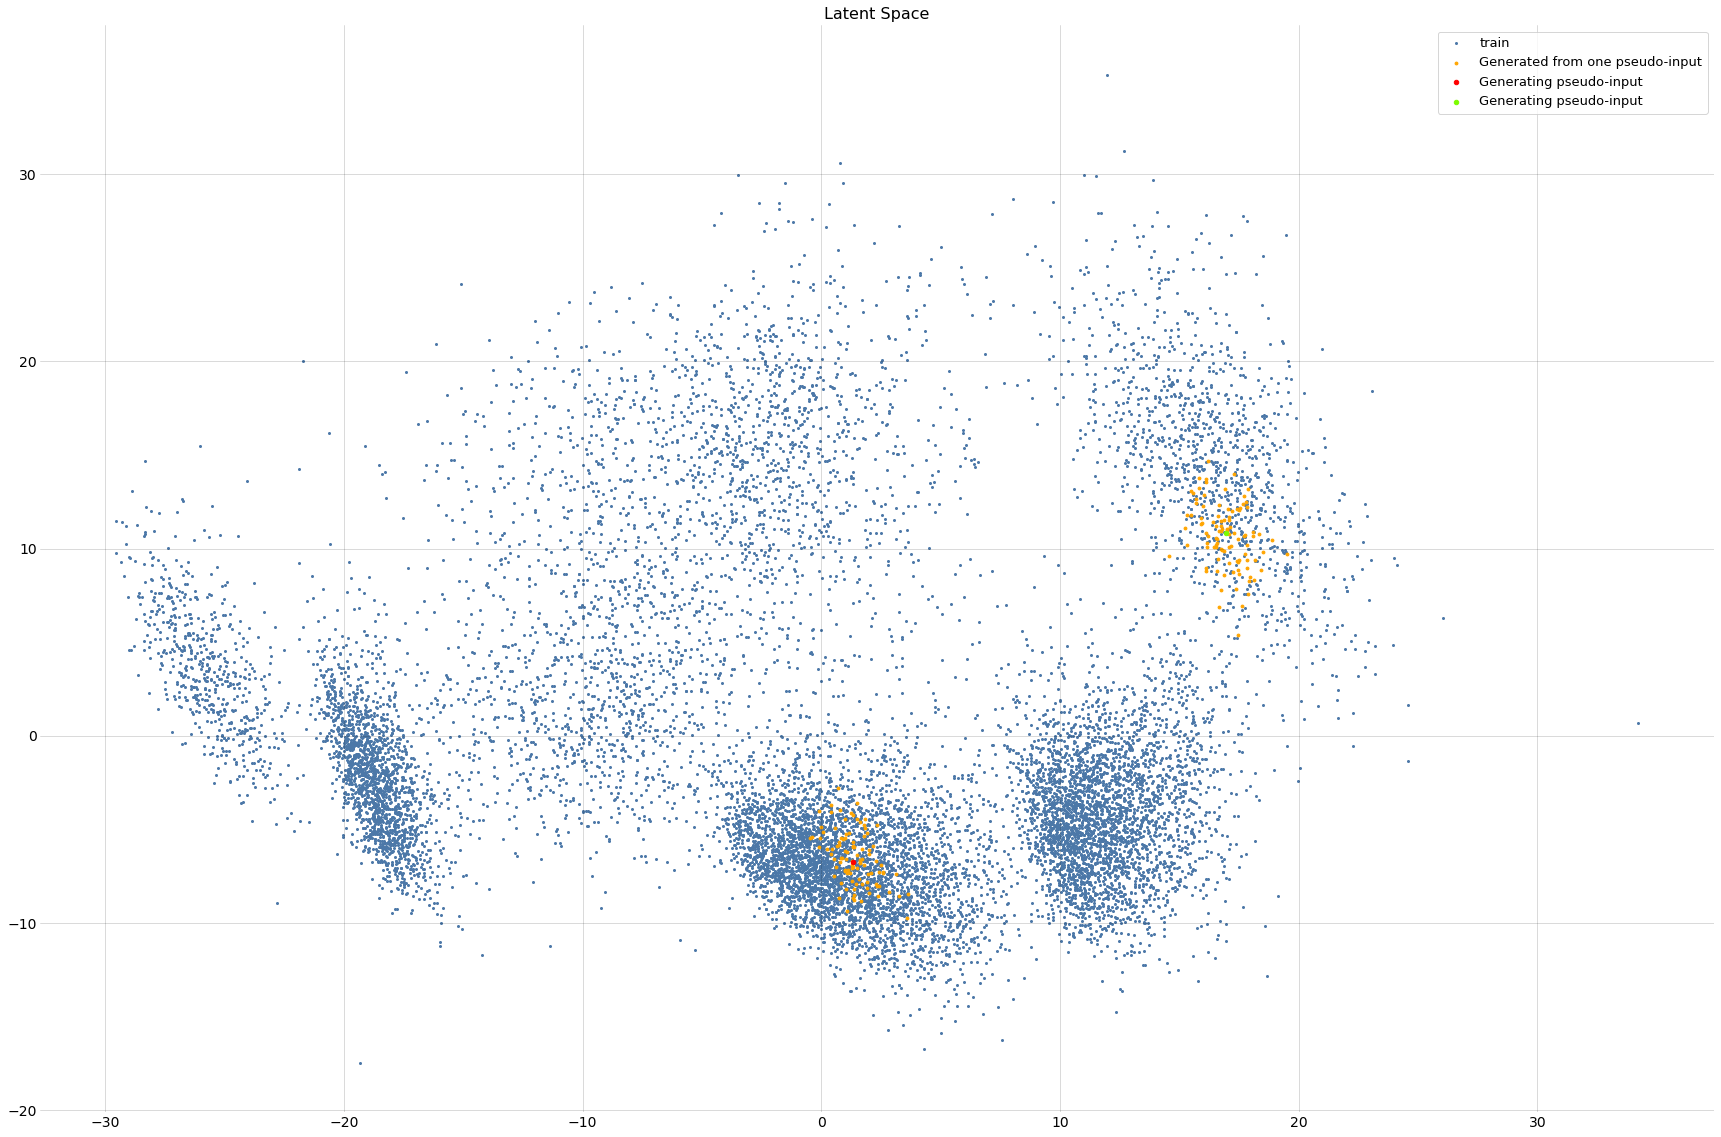

In [15]:
i = np.random.randint(int(len(pseudo_means)/2))

col = torch.norm(pseudo_scales, dim = 1, p = 2).detach().numpy()
js = np.argsort(col)[[i,-i]]
# js = [759,323]

n_gen = 100

dist1 = torch.distributions.Independent(torch.distributions.Normal(pseudo_means[js[0]], pseudo_scales[js[0]]), 1)
gen1 = dist1.sample(torch.Size([n_gen]))

dist2 = torch.distributions.Independent(torch.distributions.Normal(pseudo_means[js[1]], pseudo_scales[js[1]]), 1)
gen2 = dist2.sample(torch.Size([n_gen]))

gen = torch.cat((gen1, gen2, pseudo_means[js]), axis=0)
out = t.decode(gen)
out_traf = g.build_traffic(out, coordinates = dict(latitude = 47.546585, longitude = 8.447731), forward=False)

concat = np.concatenate((z_train, gen.detach().numpy()))
pca = PCA(n_components=2).fit(concat[:-len(gen)])
gen_embedded = pca.transform(concat)

print(js)
col = torch.norm(pseudo_scales[js], dim = 1, p = 2)
print("red scale :", col[0])
print("green scale :", col[1])

with plt.style.context("traffic"):
    fig = plt.figure(figsize=(30, 20))
    ax = fig.add_subplot(111)

    ax.scatter(gen_embedded[:-len(gen), 0], gen_embedded[:-len(gen), 1], s=4, label = "train")
    ax.scatter(gen_embedded[-len(gen):, 0], gen_embedded[-len(gen):, 1], s=8, c='orange', label = "Generated from one pseudo-input")
    ax.scatter(gen_embedded[-2, 0], gen_embedded[-2, 1], s=20, c='red', label = "Generating pseudo-input")
    ax.scatter(gen_embedded[-1, 0], gen_embedded[-1, 1], s=20, c="lawngreen", label = "Generating pseudo-input")
    ax.title.set_text("Latent Space")
    ax.legend()

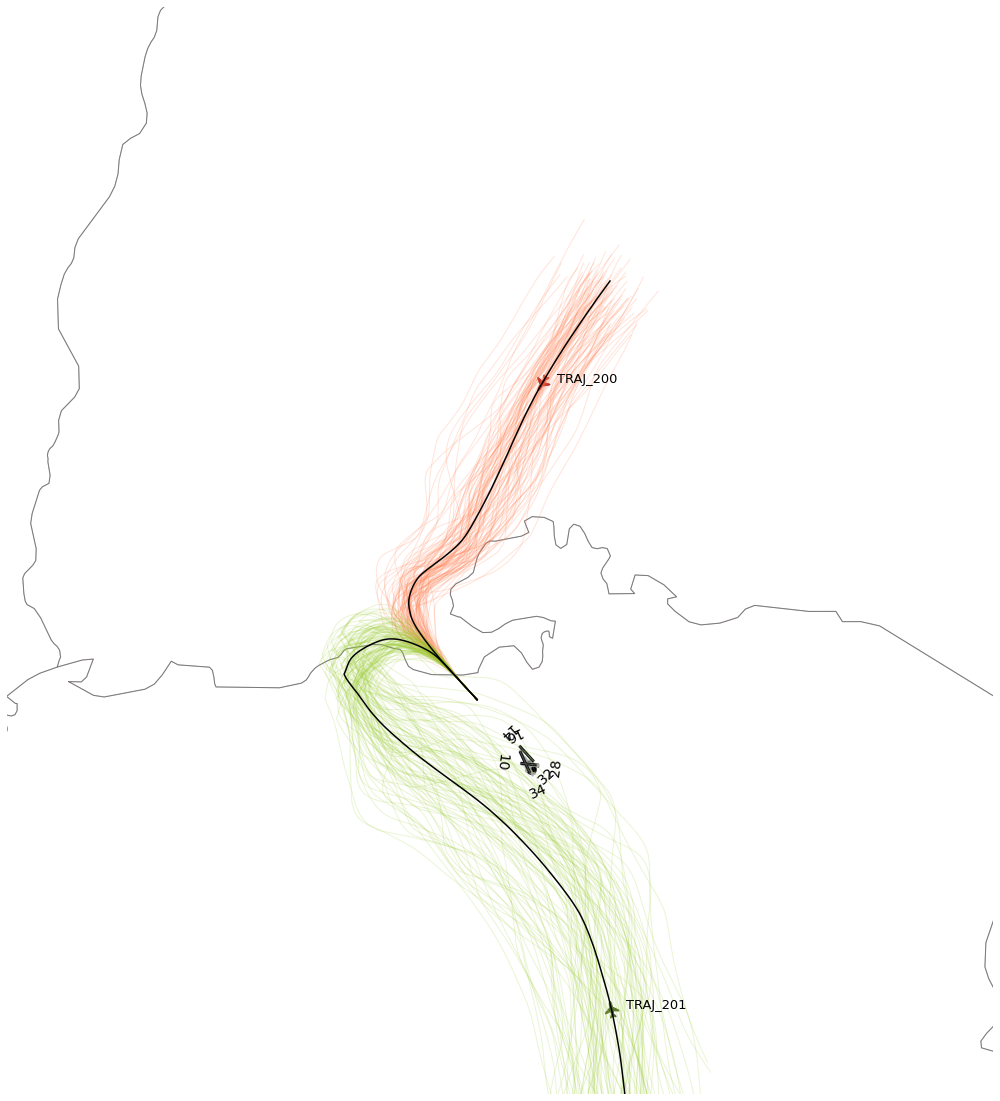

In [16]:
with plt.style.context("traffic"):
    fig = plt.figure(figsize=(30, 20))
    ax = fig.add_subplot(111, projection=EuroPP())

    ax.add_feature(countries())
    ax.figure
    ax.set_extent((7.5, 9.5, 47, 48.5))
    out_traf[["TRAJ_" + str(i) for i in range(n_gen)]].plot(ax, color="coral", alpha=0.2)
    out_traf[["TRAJ_" + str(i) for i in range(n_gen, n_gen*2)]].plot(ax, color="yellowgreen", alpha=0.2)

    out_traf["TRAJ_"+str(len(out_traf)-2)].plot(ax, color="black", lw=1.5)
    out_traf["TRAJ_"+str(len(out_traf)-2)].at_ratio(0.2).plot(
        ax,
        color="firebrick",
    )

    out_traf["TRAJ_"+str(len(out_traf)-1)].plot(ax, color="black", lw=1.5)
    out_traf["TRAJ_"+str(len(out_traf)-1)].at_ratio(0.2).plot(
        ax,
        color="darkolivegreen",
    )

    airports["LSZH"].plot(ax, footprint=True, runways=dict(lw=1), labels=False)
    airports["LSZH"].runways.plot(
        ax,
        runways=False,
        labels=True,
        shift=3000,
        text_kw=dict(fontname="Fira Sans", fontsize=14),
    )

bad : 159 - 960

good and close : 410 - 100

Nice : 759 - 323 / 408 - 659 (même si c'est pas évident dans les culsters) / 364-766 /

Boucle: 562 - 246 / 951 - 981

# Dynamic Time Wrapping

In [34]:
from traffic.core import Traffic
traffic = Traffic.from_file("../../deep_traffic_generation/data/traffic_noga_tilFAF_train.pkl") 

dataset_test = TrafficDataset.from_file(
    "../../deep_traffic_generation/data/traffic_noga_tilFAF_train.pkl",
    features=["track", "groundspeed", "altitude", "timedelta"],
    scaler=None,
    shape="image",
    info_params={"features": ["latitude", "longitude"], "index": -1},
)

dataset_test_lin = TrafficDataset.from_file(
    "../../deep_traffic_generation/data/traffic_noga_tilFAF_train.pkl",
    features=["track", "groundspeed", "altitude", "timedelta"],
    scaler=None,
    shape="linear",
    info_params={"features": ["latitude", "longitude"], "index": -1},
)

In [38]:
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from tqdm.notebook import tqdm
from scipy.signal import savgol_filter

dist = {}
closest_match = {}
min_dist = {}

#Vampprior pi
pseudo_X = t.VAE.lsr.pseudo_inputs_NN(t.VAE.lsr.idle_input) 
pseudo_X = pseudo_X.view((pseudo_X.shape[0], 4, 200))
pseudo_h = t.VAE.encoder(pseudo_X)
pseudo_means = t.VAE.lsr.z_loc(pseudo_h)

#Reconstructed pseudo-inputs
pi = t.decode(pseudo_means)
pi[:,3] = 0
#The track prediction is filtered (smoothen trajectories)
pi[:,0::4] = savgol_filter(pi[:,0::4], 11, 3)
pi = pi.reshape((pseudo_X.shape[0], 4, 200))

for j in tqdm(range(len(pi))):

    for i in range(len(dataset_test)):
        if i == j:
            continue
        dist[i] = fastdtw(pi[j], dataset_test.data[i], dist=euclidean)[0]

    mini = min(dist, key=dist.get)
    closest_match[j] = mini
    min_dist[j] = dist[mini]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [46]:
closest_match

{0: 12566,
 1: 12566,
 2: 12566,
 3: 12566,
 4: 12566,
 5: 12566,
 6: 12566,
 7: 7,
 8: 12566,
 9: 12566,
 10: 10,
 11: 11,
 12: 12566,
 13: 12566,
 14: 12566,
 15: 12566,
 16: 12566,
 17: 12566,
 18: 12566,
 19: 12566,
 20: 12566,
 21: 12566,
 22: 22,
 23: 12566,
 24: 12566,
 25: 12566,
 26: 26,
 27: 12566,
 28: 12566,
 29: 12566,
 30: 12566,
 31: 12566,
 32: 32,
 33: 12566,
 34: 12566,
 35: 12566,
 36: 12566,
 37: 37,
 38: 12566,
 39: 39,
 40: 12566,
 41: 12566,
 42: 12566,
 43: 43,
 44: 12566,
 45: 12566,
 46: 12566,
 47: 47,
 48: 12566,
 49: 49,
 50: 12566,
 51: 51,
 52: 12566,
 53: 12566,
 54: 12566,
 55: 55,
 56: 12566,
 57: 12566,
 58: 12566,
 59: 12566,
 60: 12566,
 61: 61,
 62: 12566,
 63: 63,
 64: 5865,
 65: 12566,
 66: 66,
 67: 12566,
 68: 12566,
 69: 12566,
 70: 12566,
 71: 12566,
 72: 12566,
 73: 12566,
 74: 12566,
 75: 12566,
 76: 12566,
 77: 77,
 78: 12566,
 79: 79,
 80: 12566,
 81: 12566,
 82: 82,
 83: 12566,
 84: 12566,
 85: 12566,
 86: 5865,
 87: 12566,
 88: 12566,
 8

In [42]:
pi_traf = g.build_traffic(pi, coordinates = dict(latitude = 47.546585, longitude = 8.447731), forward=False)

In [49]:
pi_traf["TRAJ_10"] | traffic[10]

In [59]:
#Same with regular euclidian distance

dist = {}
j = 1563

for i in tqdm(range(len(dataset_test))):
    if i == j:
        continue
    dist[i] = euclidean(dataset_test_lin.data[j], dataset_test_lin.data[i])

min(dist, key=dist.get)

  0%|          | 0/14000 [00:00<?, ?it/s]

13965

In [54]:
traffic[0] | traffic[12331]